# Execute the trained model (WSI level)

In [4]:
from sourcecode.unet_model import *
from sourcecode.wsi_image_utils import *

import os
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils
from torch.autograd import Variable

import gc 

torch.cuda.empty_cache()
gc.collect()


dataset_dir = "../../datasets/ORCA"
model_dir = "../../models"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"

# loads our trained fcn model
trained_model_version = "Epoch-100_Images-3111_Batch-1"
trained_model_path="{}/{}".format(model_dir, 'ORCA__Size-{}x{}_{}.pth'.format(patch_size[0], patch_size[1], trained_model_version))

if not os.path.isfile(trained_model_path):
    
    logger.info("Trained model not found: '{}'.".format(trained_model_path))
    
else:

    model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)
    
    dataset_type = "testing"
    classes = ["tumor"]
    for cls in classes:

        orca_dir = "../../datasets/ORCA"
        annotations_dir = "{}/{}/lesion_annotations".format(orca_dir, dataset_type)
        wsi_images_dir = "{}/{}/{}/wsi".format(orca_dir, dataset_type, cls)
        patch_images_dir = "{}/{}/{}/patch/640x640".format(orca_dir, dataset_type, cls)
        patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(orca_dir, trained_model_version, dataset_type, cls)
        wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(orca_dir, trained_model_version, dataset_type, cls)
        
        for r, d, f in sorted(os.walk(wsi_images_dir)):
            for wsi_file in sorted(f):

                wsi_image_file = "{}/{}".format(r, wsi_file)
                wsi_image_number = wsi_file.replace(".png", "")

                file_is_png = wsi_image_file.lower().endswith('.png')
                if file_is_png:

                    logger.info("Processing wsi '{}'".format(wsi_file))
                    if not os.path.isfile(wsi_image_file):
                        logger.info("WSI image not found: '{}'.".format(wsi_file))
                        break
                    
                    # check directory to save image-patches
                    dir_to_save = "{}/{}".format(patch_images_results_dir, wsi_image_number)
                    if not os.path.exists(dir_to_save):
                        os.makedirs("{}/{}".format(wsi_images_results_dir, wsi_image_number))
                        os.makedirs("{}/01-unet_result".format(dir_to_save))
                        
                    # scale down image
                    wsi_image = open_wsi(wsi_image_file)
                    pil_scaled_down_image = scale_down_wsi(wsi_image, magnification, False)
                    np_scaled_down_image = pil_to_np(pil_scaled_down_image)

                    # extract tissue region 
                    np_tissue_mask, np_masked_image = extract_normal_region_from_wsi(wsi_image_file, np_scaled_down_image, None)
                    pil_masked_image = np_to_pil(np_masked_image)

                    # draw the heat grid
                    pil_img_result, heat_grid, number_of_tiles = draw_heat_grid(np_masked_image, tile_size)

                    # run the model
                    count_tiles = 0
                    count_roi_tiles = 0
                    for idx, (position, row, column, location, size, color) in enumerate(heat_grid):

                        if color != GREEN_COLOR:

                            count_tiles += 1

                            r_s = row * tile_size
                            r_e = r_s + tile_size
                            c_s = column * tile_size
                            c_e = c_s + tile_size
                            np_tile_masked = np_masked_image[r_s:r_e, c_s:c_e]

                            # only tile with valid size
                            if np_tile_masked.shape[0] == tile_size and np_tile_masked.shape[1] == tile_size:

                                # read the tile from the original wsi image
                                pil_input_tile, np_input_tile = read_region(wsi_image_file, column, row, magnification, tile_size)

                                # run the model
                                if color_model == "LAB":
                                    np_input_tile = rgb_to_lab(np_input_tile)

                                X = torch.from_numpy(np_input_tile).permute(2, 0, 1).float()
                                X = Variable(X.unsqueeze(0)).to(device) if use_cuda else X.unsqueeze(0)
                                y_hat = model(X).detach().cpu().squeeze(0)
                                #y_hat = model(X).squeeze(0)
                                output_tile = y_hat[0]
                                np_output_tile = output_tile.squeeze(0).detach().cpu().numpy()
                                #

                                # only tiles that something was found by model
                                if np.any(np.unique(np_output_tile >= 0.1)):

                                    # save the output image-patch results
                                    utils.save_image(output_tile, '{}/01-unet_result/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))

                                    np_output_tile[np_output_tile > 0] = 1
                                    count_roi_tiles += 1

                    logger.info("\t '{}/{}/{}' tiles identified as ROI by model".format(count_roi_tiles, count_tiles, len(heat_grid)))
                    logger.info("-")

                    # save scaled down wsi
                    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                        

2021-02-01 11:06:17,375 :: INFO load_checkpoint :: 	 Model loaded on: cpu / 3 / 1 / (640, 640) -> ../../models/ORCA__Size-640x640_Epoch-100_Images-3111_Batch-1.pth
2021-02-01 11:06:17,390 :: INFO <module> :: Processing wsi 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_0.png'
2021-02-01 11:06:18,725 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_0.png'
2021-02-01 11:13:49,197 :: INFO <module> :: 	 '49/49/49' tiles identified as ROI by model
2021-02-01 11:13:49,198 :: INFO <module> :: -
2021-02-01 11:13:49,204 :: INFO <module> :: Processing wsi 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1.png'
2021-02-01 11:13:50,883 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1.png'


KeyboardInterrupt: 

# Generate the heatmaps (WSI level)

2021-02-01 11:16:19,648 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_0.png'
2021-02-01 11:16:20,663 :: INFO <module> :: 	 '49' tiles identified as ROI after post processing
2021-02-01 11:16:20,666 :: INFO <module> :: -
2021-02-01 11:16:20,933 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1.png'
2021-02-01 11:16:20,935 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:20,936 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1/01-unet_result
2021-02-01 11:16:20,940 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4725-01Z-00-DX1.fe518acf-cceb-4be4-b01a-63d66248d6d4_0.png'
2021-02-01 11:16:20,942 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:20,943 ::

2021-02-01 11:16:21,029 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-4734-01Z-00-DX1.9cd35e43-7132-478a-9d08-a88d150b7127_0/01-unet_result
2021-02-01 11:16:21,032 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4734-01Z-00-DX1.9cd35e43-7132-478a-9d08-a88d150b7127_1.png'
2021-02-01 11:16:21,035 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,037 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-4734-01Z-00-DX1.9cd35e43-7132-478a-9d08-a88d150b7127_1/01-unet_result
2021-02-01 11:16:21,039 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4735-01Z-00-DX1.b7d37666-bd65-4d3b-826b-97e560444956_0.png'
2021-02-01 11:16:21,040 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,042 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-311

2021-02-01 11:16:21,141 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5355-01Z-00-DX1.8fb23e44-fc59-4191-b825-cc021807a338_1.png'
2021-02-01 11:16:21,143 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,145 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-5355-01Z-00-DX1.8fb23e44-fc59-4191-b825-cc021807a338_1/01-unet_result
2021-02-01 11:16:21,147 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5356-01Z-00-DX1.53360c41-d0d2-465e-8b53-ccd1a2ce248f_0.png'
2021-02-01 11:16:21,148 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,150 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-5356-01Z-00-DX1.53360c41-d0d2-465e-8b53-ccd1a2ce248f_0/01-unet_result
2021-02-01 11:16:21,151 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5356-01Z-00-DX1.533

2021-02-01 11:16:21,231 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,232 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-5366-01Z-00-DX1.dcc14c44-6dd1-48a1-a21c-736c6b9551e1_1/01-unet_result
2021-02-01 11:16:21,233 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5367-01Z-00-DX1.5b09e54e-4140-4709-bc60-e201f9a72b24_0.png'
2021-02-01 11:16:21,235 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,235 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-5367-01Z-00-DX1.5b09e54e-4140-4709-bc60-e201f9a72b24_0/01-unet_result
2021-02-01 11:16:21,237 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5367-01Z-00-DX1.5b09e54e-4140-4709-bc60-e201f9a72b24_1.png'
2021-02-01 11:16:21,238 :: INFO <module> :: 	 This WSI image was not processed by our fcn base

2021-02-01 11:16:21,306 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-6017-01Z-00-DX1.690fa1af-4b51-41c8-a52d-bd1341f990e9_1/01-unet_result
2021-02-01 11:16:21,310 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6018-01Z-00-DX1.77855643-92a9-40a7-b4a8-0e32b89fc597_0.png'
2021-02-01 11:16:21,313 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,314 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-6018-01Z-00-DX1.77855643-92a9-40a7-b4a8-0e32b89fc597_0/01-unet_result
2021-02-01 11:16:21,317 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6018-01Z-00-DX1.77855643-92a9-40a7-b4a8-0e32b89fc597_1.png'
2021-02-01 11:16:21,319 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,320 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-311

2021-02-01 11:16:21,400 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6994-01Z-00-DX1.0aa71a4c-25e5-417d-86cf-ce2756e3dd8a_0.png'
2021-02-01 11:16:21,402 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,403 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-6994-01Z-00-DX1.0aa71a4c-25e5-417d-86cf-ce2756e3dd8a_0/01-unet_result
2021-02-01 11:16:21,404 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6994-01Z-00-DX1.0aa71a4c-25e5-417d-86cf-ce2756e3dd8a_1.png'
2021-02-01 11:16:21,405 :: INFO <module> :: 	 This WSI image was not processed by our fcn based method yet.
2021-02-01 11:16:21,406 :: INFO <module> :: 	 ../../datasets/ORCA/results/Epoch-100_Images-3111_Batch-1/testing/tumor/patch/640x640/TCGA-CN-6994-01Z-00-DX1.0aa71a4c-25e5-417d-86cf-ce2756e3dd8a_1/01-unet_result
2021-02-01 11:16:21,407 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6996-01Z-00-DX1.b3a

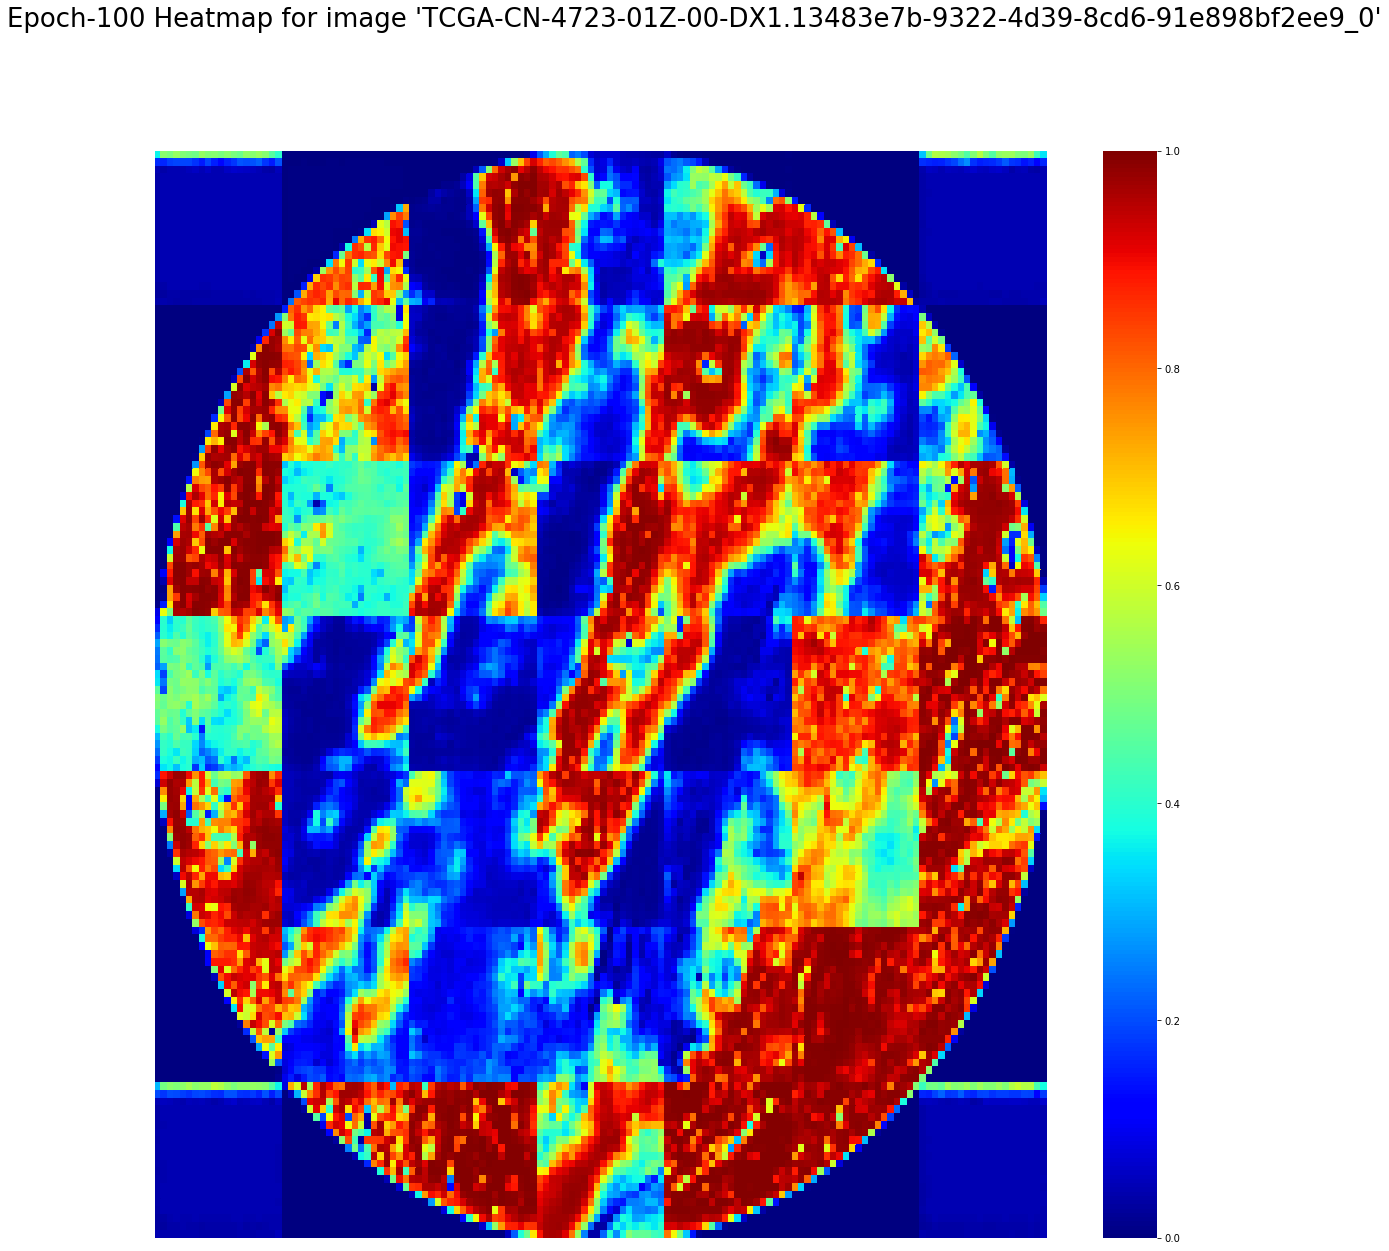

In [6]:
from sourcecode.wsi_image_utils import *

import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils


dataset_dir = "../../datasets/ORCA"
model_dir = "../../models"
trained_model_version = "Epoch-100_Images-3111_Batch-1"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)


dataset_type = "testing"
classes = ["tumor"]
for cls in classes:

    orca_dir = "../../datasets/ORCA"
    annotations_dir = "{}/{}/lesion_annotations".format(orca_dir, dataset_type)
    wsi_images_dir = "{}/{}/{}/wsi".format(orca_dir, dataset_type, cls)
    patch_images_dir = "{}/{}/{}/patch/640x640".format(orca_dir, dataset_type, cls)
    patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(orca_dir, trained_model_version, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(orca_dir, trained_model_version, dataset_type, cls)

    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".png", "")

            file_is_png = wsi_image_file.lower().endswith('.png')
            if file_is_png:

                logger.info("Segmenting wsi image: '{}'".format(wsi_file))
                unet_results_dir = "{}/{}/01-unet_result".format(patch_images_results_dir, wsi_image_number)
                if not os.path.exists(unet_results_dir):
                    logger.info("\t This WSI image was not processed by our fcn based method yet.")
                    logger.info("\t {}".format(unet_results_dir))
                    continue
                
                original_img_path = "{}/{}/{}.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                pil_original_image = load_pil_image(original_img_path, gray=False)
                np_scaled_down_image = pil_to_np(pil_original_image)

                # fcn roi identification
                count_tiles = 0
                np_heatmap = np.zeros((np_scaled_down_image.shape[0], np_scaled_down_image.shape[1]))
                np_tissue_roi = np.zeros_like(np_scaled_down_image)
                for _, _, unet_tile_files in sorted(os.walk(unet_results_dir)):
                    for unet_tile_image_file in sorted(unet_tile_files):
                        if os.path.isfile("{}/{}".format(unet_results_dir, unet_tile_image_file)):

                            # load the unet image-patch result
                            np_tile_unet = np.copy(pil_to_np(load_pil_image("{}/{}".format(unet_results_dir, unet_tile_image_file), gray=True)))
                            np_tile_unet = np_tile_unet * (1.0/255)
                            np_tile_unet[np.isnan(np_tile_unet)] = 0

                            # check if exists values greather than 0.x
                            if np.any(np.unique(np_tile_unet > 0.1)):

                                aux_row_column = unet_tile_image_file.split("_")[-1].replace(".png", "").split('c')
                                row = int(aux_row_column[0].replace("r", ""))
                                column = int(aux_row_column[-1])

                                r_s = row * tile_size
                                r_e = r_s + tile_size
                                c_s = column * tile_size
                                c_e = c_s + tile_size
                                np_heatmap[r_s:r_e, c_s:c_e] = image_resize(np_tile_unet, height=tile_size)

                                np_tile_unet = basic_threshold(np_tile_unet, threshold=0.01, output_type="uint8")
                                tissue_area = tissue_percent(np_tile_unet)
                                if tissue_area > 1:

                                    count_tiles += 1

                                else:
                                    np_heatmap[r_s:r_e, c_s:c_e] = 0

                logger.info("\t '{}' tiles identified as ROI after post processing".format(count_tiles))
                logger.info("-")
                
                f = plt.figure(figsize=((np_heatmap.shape[1]*20)/np_heatmap.shape[0], 20))
                f.suptitle("{} Heatmap for image '{}'".format(trained_model_version.split("_")[0], wsi_image_number), fontsize=26)

                ax1 = f.add_subplot(111)
                sns.heatmap(np_heatmap, ax=ax1, xticklabels=False, yticklabels=False, vmin=0, vmax=1, cmap="jet", cbar=True, robust=True)

                f.savefig(original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap.png".format(wsi_image_number)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap)), original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap_gray.png".format(wsi_image_number)))

# Generate the lesion localization points (WSI level)

In [2]:
from sourcecode.wsi_image_utils import *

import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils

from scipy import ndimage as nd
from skimage import measure

dataset_dir = "../../datasets/CAMELYON16"
model_dir = "../../models"
trained_model_version = "Epoch-10_Images-109278_Batch-1"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

threshold_prob = 0.5
threshold_itc = 200/(0.243 * pow(2, 5))

dataset_type = "testing"
classes = ["tumor", "normal"]
for cls in classes:

    camelyon16_dir = "../../datasets/CAMELYON16"
    wsi_images_dir = "{}/{}/{}/wsi".format(camelyon16_dir, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(camelyon16_dir, trained_model_version, dataset_type, cls)

    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".tif", "")

            file_is_tif = wsi_image_file.lower().endswith('.tif')
            if file_is_tif:
                
                logger.info("Generating the lesion localization points for wsi image: '{}'".format(wsi_file))
                
                heatmap_gray_path = "{}/{}/{}_heatmap_gray.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                if not os.path.exists(heatmap_gray_path):
                    logger.info("\t This original WSI image was not processed yet.")
                    logger.info("\t {}".format(heatmap_gray_path))
                    continue
                                
                np_heatmap_gray = load_np_image(heatmap_gray_path, color_model="GRAY") * (1.0/255)
                np_heatmap_points = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                np_heatmap_convex = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))

                seg_threshold_img = basic_threshold(np_heatmap_gray, threshold=threshold_prob, output_type="uint8")
                seg_threshold_img = nd.morphology.binary_fill_holes(seg_threshold_img)
                
                seg_threshold_img_labels = measure.label(seg_threshold_img, connectivity=2)
                seg_threshold_img = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                
                properties = measure.regionprops(seg_threshold_img_labels)
                
                csv_file_path = heatmap_gray_path.replace("_heatmap_gray.png", ".csv")
                with open(csv_file_path, mode='w') as result_file:

                    result_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                                        
                    labels = np.unique(seg_threshold_img_labels)
                    for lbl in range(1, (np.max(labels)+1)):
                        
                        centroid = (int(properties[lbl-1].centroid[0]), int(properties[lbl-1].centroid[1]))
                        major_axis_length = properties[lbl-1].major_axis_length
                        
                        if major_axis_length > threshold_itc:

                            hull = properties[lbl-1].convex_image
                            bbox = properties[lbl-1].bbox
                            #mean_intensity = np.mean(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                            #centroid_intensity = np_heatmap_gray[centroid[0], centroid[1]]
                            max_intensity = np.max(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                                                        
                            prob = max_intensity
                            if prob > 0.0:
                                
                                #print("   {:04.2f}, {}, {}".format(prob, centroid[1], centroid[0]))
                                seg_threshold_img[seg_threshold_img_labels == lbl] = 1
                                
                                result_writer.writerow(["{:04.2f}".format(prob), centroid[1], centroid[0]])
                                np_heatmap_points[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 1
                                np_heatmap_convex[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True] = 1
                                np_heatmap_convex[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 0.5
                        
                utils.save_image(TF.to_tensor(np_to_pil(seg_threshold_img)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}".format(threshold_prob)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_points)), heatmap_gray_path.replace("_gray", "_points"))
                #utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_convex)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}_convex".format(threshold_prob)))


2021-01-07 21:12:55,773 :: INFO <module> :: Generating the lesion localization points for wsi image: 'test_001.tif'
2021-01-07 21:12:58,772 :: INFO <module> :: Generating the lesion localization points for wsi image: 'test_003.tif'


# Execute the trained model (image-patch level)

In [1]:
from camelyon16_train import *
from camelyon16_dataloader import *

import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision import utils
from datetime import datetime

from scipy import ndimage as nd
from skimage import measure

camelyon16_dir = "../../datasets/CAMELYON16"
model_dir = "../../models"

batch_size = 1
patch_size = (640, 640)
color_model = "LAB"
dataloaders = create_dataloader(tile_size="{}x{}".format(patch_size[0], patch_size[1]),
                                batch_size=batch_size, 
                                shuffle=False,
                                img_input_size=patch_size,
                                img_output_size=patch_size,
                                dataset_dir=camelyon16_dir,
                                color_model=color_model)

dataset_train_size = len(dataloaders['train'].dataset)
dataset_test_size = len(dataloaders['test'].dataset)


threshold_prob = 0.50
threshold_itc = 200/(0.243 * pow(2, 5))


# Checking for GPU availability
use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"
logger.info('Runing on: {}'.format(device))

# loads our trained fcn model
trained_model_version = "Epoch-10_Images-109278_Batch-1"
trained_model_path="{}/{}".format(model_dir, 'OCDC+CAMELYON16__Size-{}x{}_{}.pth'.format(patch_size[0], patch_size[1], trained_model_version))
model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)
cont = 0
for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):
        
    X = Variable(images).to(device) if use_cuda else images
    logger.info('Batch {}: {}/{} images: {} masks: {} {}'.format(
                (batch_idx+1), 
                (batch_idx+1) * len(images), 
                len(dataloaders['test'].dataset),
                images.shape,
                masks.shape,
                datetime.now().strftime('%d/%m/%Y %H:%M:%S')))
    
    #X_numpy = X.cpu().numpy()
    y_hat = model(X).detach().cpu().squeeze(0)
    cls = "tumor" if np.max(np.unique(masks[0].numpy())) > 0 else 'normal'
    
    input_image = transforms.ToPILImage()(X.squeeze(0).cpu())
    output_mask = basic_threshold(y_hat[0].detach().cpu().numpy(), threshold=threshold_prob, output_type="uint8")

    predicted_labels = measure.label(output_mask, connectivity=2)
    output_mask = np.zeros((output_mask.shape[0], output_mask.shape[1]))
    labels = np.unique(predicted_labels)
    properties = measure.regionprops(predicted_labels)
    for lbl in range(1, (np.max(labels)+1)):
        major_axis_length = properties[lbl-1].major_axis_length
        if major_axis_length > threshold_itc:
            output_mask[predicted_labels == lbl] = 1

    input_image_rgb = lab_to_rgb(pil_to_np(input_image))
    roi_image = blend_image(np_to_pil(input_image_rgb), np_to_pil(output_mask), foreground='red', inverse=True)

    # results dir
    wsi_image_number = fname[0].split("_")[0] + "_" + fname[0].split("_")[1]
    patch_images_results_dir = "{}/results/{}/testing/{}/patch/640x640/{}".format(camelyon16_dir, trained_model_version, cls, wsi_image_number)
    results_output_dir = "{}/01-unet_result".format(patch_images_results_dir)
    results_roi_dir = "{}/02-roi".format(patch_images_results_dir)
    if not os.path.exists(results_roi_dir):
        os.makedirs(results_output_dir)
        os.makedirs(results_roi_dir)

    # save the results
    patch_img_name = fname[0]
    utils.save_image(y_hat[0], '{}/{}'.format(results_output_dir, patch_img_name))
    utils.save_image(TF.to_tensor(roi_image), '{}/{}'.format(results_roi_dir, patch_img_name))

2021-01-07 21:03:31,688 :: INFO load_dataset :: [training] ../../datasets/CAMELYON16/training
2021-01-07 21:03:31,708 :: INFO load_dataset :: [testing] ../../datasets/CAMELYON16/testing
2021-01-07 21:03:31,728 :: INFO create_dataloader :: Train images (640x640): 10 (augmentation: True)
2021-01-07 21:03:31,729 :: INFO create_dataloader :: Test images (640x640): 10 (augmentation: False)
2021-01-07 21:03:31,731 :: INFO <module> :: Runing on: cpu
2021-01-07 21:03:32,608 :: INFO load_checkpoint :: 	 Model loaded on: cpu / 3 / 1 / (640, 640) -> ../../models/OCDC+CAMELYON16__Size-640x640_Epoch-10_Images-109278_Batch-1.pth
2021-01-07 21:03:32,879 :: INFO <module> :: Batch 1: 1/10 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 07/01/2021 21:03:32
2021-01-07 21:03:42,821 :: INFO <module> :: Batch 2: 2/10 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 07/01/2021 21:03:42
2021-01-07 21:03:54,275 :: INFO <module> :: Batch 3: 3/10 images: torch.Size([1, 